## Table of Content

## Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import re
import string

from PIL import Image

from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

We only need to load articles data in this part

In [27]:
#Loading Data
articles_df = pd.read_pickle('../data/processed/cleaned_articles.pkl')
transactions_df = pd.read_pickle('../data/processed/cleaned_transactions.pkl')

In [3]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105107 entries, 0 to 105106
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   article_id                    105107 non-null  int64  
 1   product_code                  105107 non-null  int64  
 2   prod_name                     105107 non-null  object 
 3   product_type_no               105107 non-null  int64  
 4   product_type_name             105107 non-null  object 
 5   product_group_name            105107 non-null  object 
 6   graphical_appearance_no       105107 non-null  int64  
 7   graphical_appearance_name     105107 non-null  object 
 8   colour_group_code             105107 non-null  int64  
 9   colour_group_name             105107 non-null  object 
 10  perceived_colour_value_id     105107 non-null  int64  
 11  perceived_colour_value_name   105107 non-null  object 
 12  perceived_colour_master_id    105107 non-nul

## Preprocessing Data

For our Content Base Recommnedation system, we will not be using the majority of the columns in the articles_df. So, we can proceed by dropping the columns that are unnecessary for our recommendation systems and export the csv for later use.



In [4]:
articles_df = articles_df[[
    'article_id',
    'product_type_name',
    'index_group_name',
    'section_name',
    'product_group_name',
    'garment_group_name',
    'colour_group_name',
    'preprocessed_desc'
    ]]


In [5]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105107 entries, 0 to 105106
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   article_id          105107 non-null  int64 
 1   product_type_name   105107 non-null  object
 2   index_group_name    105107 non-null  object
 3   section_name        105107 non-null  object
 4   product_group_name  105107 non-null  object
 5   garment_group_name  105107 non-null  object
 6   colour_group_name   105107 non-null  object
 7   preprocessed_desc   105107 non-null  object
dtypes: int64(1), object(7)
memory usage: 7.2+ MB


When suggesting similar products, Color is an important factor. To improve the quality of our text features, we’re adding the colour_group_name to the detail_desc column. This helps capture more complete information, as the original descriptions don’t include color.

In [6]:
# Add colour_group_name to detail_desc
articles_df.loc[:, 'preprocessed_desc'] = articles_df.apply(
    lambda row: f"{row['preprocessed_desc']} Color: {row['colour_group_name']}", axis=1
)

In [7]:
articles_df[['article_id', 'preprocessed_desc']].head(2)

,article_id,preprocessed_desc
0,108775015,jersey top narrow shoulder strap Color: Black
1,108775044,jersey top narrow shoulder strap Color: White


## Modelling



In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_article(article_id, articles_df, image_dir):
    # Get article row
    article = articles_df[articles_df['article_id'] == article_id].iloc[0]
    
    # Extract and format image path
    article_id_str = str(article_id).zfill(10)  # Ensure it has 10 digits
    folder = article_id_str[:3]
    filename = f"{article_id_str}.jpg"
    image_path = os.path.join(image_dir, folder, filename)

    # Plot
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)
        plt.figure(figsize=(4, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Article ID: {article_id}\n{article['product_type_name']}", fontsize=10)
        plt.show()

        print("📌 Description:")
        print(article['detail_desc'] if 'detail_desc' in article else "No description found.")
    else:
        print(f"Image not found at path: {image_path}")


In [69]:
articles_df['article_id'].tail()

105102    953450001
105103    953763001
105104    956217002
105105    957375001
105106    959461001
Name: article_id, dtype: int64

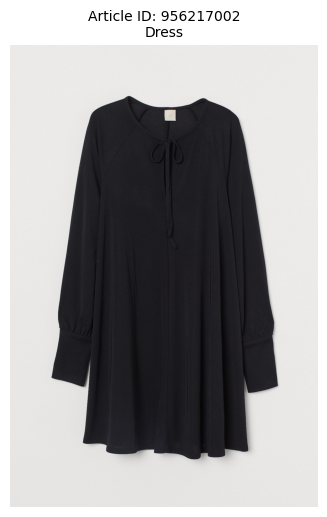

📌 Description:
Short, A-line dress in jersey with a round neckline and V-shaped opening at the front with narrow ties. Long, voluminous raglan sleeves and wide cuffs with covered buttons.


In [70]:
# Set your local path to the images folder (e.g., "../images/")
image_dir = "../data/images"

# Show article by ID
sample_id = 956217002  # replace with any valid article_id
show_article(sample_id, articles_df, image_dir)


### TF-IDF:

#### Vectorize preprocessed_desc

Here I turn the cleaned description column into numerical vectors, using ***TF-IDF***

In [19]:

from sklearn.feature_extraction.text import TfidfVectorizer

#Define a Tfid Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

#Fit and Transform our description with Tfid Vectorizer
desc_tfidf = tfidf_vectorizer.fit_transform(articles_df['preprocessed_desc'])



### KNN to Find Similar Articles

In [20]:
from sklearn.neighbors import NearestNeighbors

# Initialize model — use cosine distance
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn.fit(desc_tfidf)

# Get top-5 similar items for each article
distances, indices = knn.kneighbors(desc_tfidf)



In [21]:
article_ids = articles_df['article_id'].values

# Map indices to article IDs
similar_articles = {
    article_ids[i]: article_ids[indices[i][1:]]  
    for i in range(len(article_ids))
}


In [22]:
# article_id = 108775015
# similar_ids = similar_articles[article_id]
# articles_df[articles_df['article_id'].isin(similar_ids)][['article_id', 'product_type_name', 'preprocessed_desc']]


In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def get_image_path(article_id, image_base_path):
    article_id_str = str(article_id).zfill(10)
    folder = article_id_str[:3]
    filename = f"{article_id_str}.jpg"
    return os.path.join(image_base_path, folder, filename)


In [39]:
def show_similar_articles(selected_article_id, similar_articles,  image_base_path='../data/images'):
    similar_ids = similar_articles[selected_article_id]
    all_ids = [selected_article_id] + list(similar_ids)
    
    plt.figure(figsize=(15, 4))
    
    for i, article_id in enumerate(all_ids):
        img_path = get_image_path(article_id, image_base_path)
        try:
            img = Image.open(img_path)
            plt.subplot(1, len(all_ids), i + 1)
            plt.imshow(img)
            plt.axis('off')
            title = "Query" if i == 0 else f"Similar {i}"
            plt.title(title, fontsize=10)
        except FileNotFoundError:
            print(f"Image not found for article {article_id}")
    
    plt.tight_layout()
    plt.show()


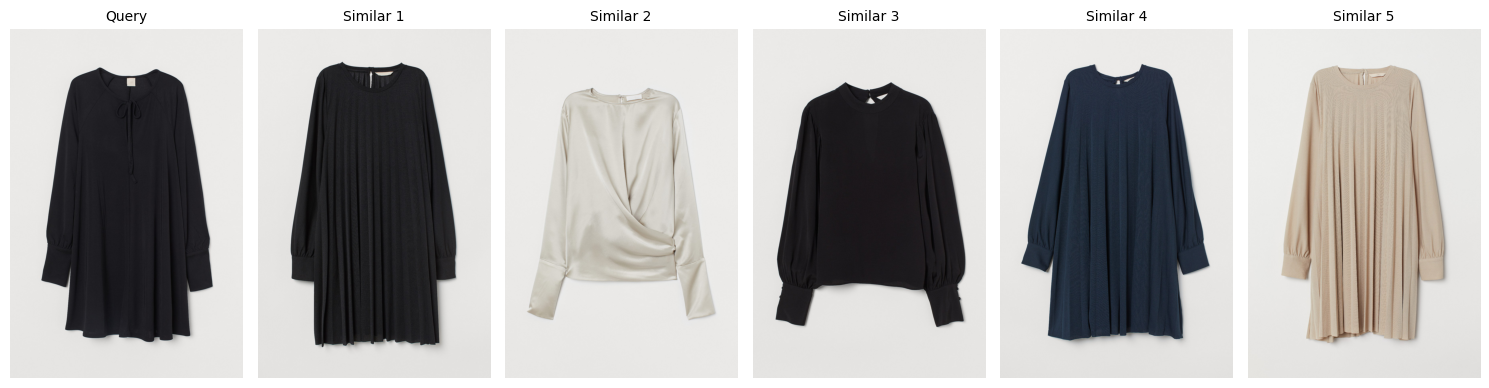

In [71]:
# Choose a sample article ID from your dataset
# sample_article_id = 108775015
sample_article_id = 956217002

# Show similar articles based on your earlier similarity dict
show_similar_articles(sample_article_id, similar_articles, image_base_path='../data/images')


In [60]:
sample_article_id = 108775015

We can print cleaned descriptions for selected article and similar atricles to show why they were matched:

In [26]:
print("Query article description:")
print(articles_df[articles_df['article_id'] == sample_article_id]['preprocessed_desc'].values[0])

print("\nSimilar articles descriptions:")
for sim_id in similar_articles[sample_article_id]:
    desc = articles_df[articles_df['article_id'] == sim_id]['preprocessed_desc'].values[0]
    print(f"- {sim_id}: {desc}")


Query article description:
jersey top narrow shoulder strap Color: Black

Similar articles descriptions:
- 623522001: fit jersey top narrow shoulder strap Color: Black
- 108775044: jersey top narrow shoulder strap Color: White
- 623522002: fit jersey top narrow shoulder strap Color: White
- 623522004: fit jersey top narrow shoulder strap Color: White
- 377277001: short fit jersey top narrow shoulder strap Color: Black


In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [10]:

article_texts = articles_df['preprocessed_desc'].tolist()

# Generate embeddings
bert_embeddings = model.encode(article_texts, show_progress_bar=True)


Batches:   0%|          | 0/3285 [00:00<?, ?it/s]

In [34]:
# bert_embeddings is a list or array of sentence vectors

from sklearn.neighbors import NearestNeighbors
bert_knn = NearestNeighbors(n_neighbors=6,  
                       metric='cosine', 
                       algorithm='brute') 
bert_knn.fit(bert_embeddings)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [35]:
# Get top 5 similar articles for each (excluding itself)
distances, indices = bert_knn.kneighbors(bert_embeddings)


In [14]:
bert_similar_articles_knn = {}

for i, article_id in enumerate(articles_df['article_id']):
    neighbors = indices[i][1:]  # Skip the first one (it's the article itself)
    neighbor_ids = articles_df.iloc[neighbors]['article_id'].tolist()
    bert_similar_articles_knn[article_id] = neighbor_ids


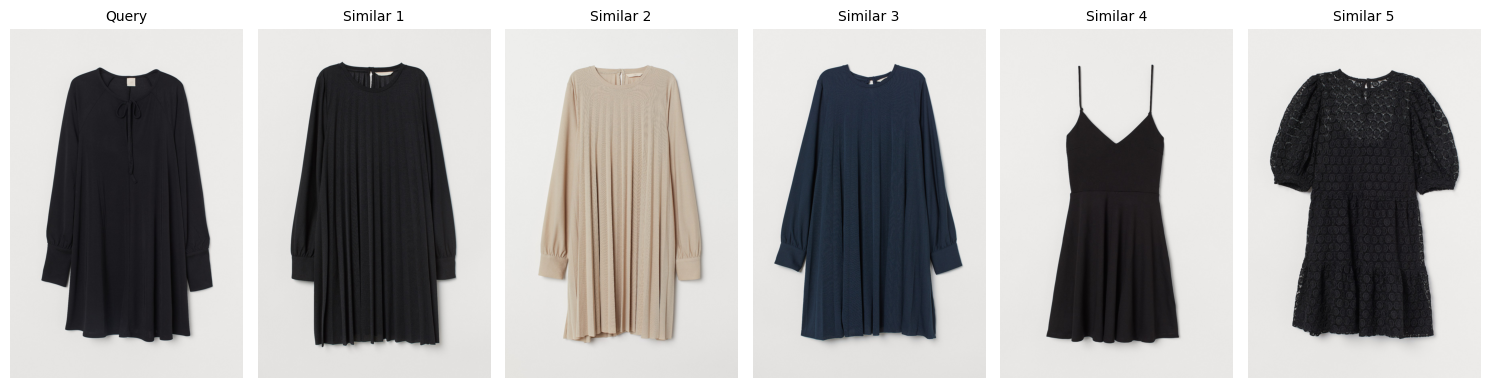

In [72]:
# Choose a sample article ID from your dataset
# sample_article_id = 108775015
sample_article_id = 956217002

# Show similar articles based on your earlier similarity dict
show_similar_articles(sample_article_id, bert_similar_articles_knn, image_base_path='../data/images')


In [ ]:
By running a couple of articles, we see that  Bert is working better here to show similarities. like the one above!

In [50]:
def compute_hit_rate(transactions_df, sim_dict, k=10):
    """
    Evaluate hit rate of recommendations using transaction history.
    """
    hit = 0
    total = 0
    
    # Group purchases by customer
    cust_purchases = transactions_df.groupby('customer_id')['article_id'].apply(list)
    
    for cust, articles in cust_purchases.items():
        if len(articles) < 2:
            continue
        
        for i in range(len(articles) - 1):
            base = articles[i]
            actual_next = articles[i + 1]
            if base in sim_dict:
                recs = sim_dict[base][:k]
                if actual_next in recs:
                    hit += 1
                total += 1
                
    return hit / total if total else 0


In [52]:
tfidf_hit = compute_hit_rate(transactions_df, similar_articles, k=10)
bert_hit = compute_hit_rate(transactions_df, bert_similar_articles_knn, k=10)

print(f"TF-IDF Hit Rate@10: {tfidf_hit:.2f}")
print(f"BERT Hit Rate@10: {bert_hit:.2f}")


TF-IDF Hit Rate@10: 0.05
BERT Hit Rate@10: 0.05


In [28]:
article_id_to_index = {aid: idx for idx, aid in enumerate(articles_df['article_id'])}
index_to_article_id = {v: k for k, v in article_id_to_index.items()}


In [29]:
customer_purchases = transactions_df.groupby('customer_id')['article_id'].apply(list)


In [36]:
def recommend_for_customer(customer_id, top_k=5):
    purchased_ids = transactions_df[transactions_df['customer_id'] == customer_id]['article_id'].tolist()
    recommended_ids = set()

    for pid in purchased_ids:
        idx = article_id_to_index.get(pid)
        if idx is not None:
            _, indices = bert_knn.kneighbors([bert_embeddings[idx]])
            for i in indices[0]:
                recommended_ids.add(index_to_article_id[i])

    # Remove already purchased articles
    recommended_ids = list(recommended_ids - set(purchased_ids))

    return recommended_ids[:top_k], purchased_ids[:top_k]  # Return both for visualization


In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_article_images(article_ids, title, base_path='../data/images'):
    plt.figure(figsize=(15, 3))
    for i, aid in enumerate(article_ids):
        try:
            img_path = get_image_path(aid, base_path)
            img = mpimg.imread(img_path)
            plt.subplot(1, len(article_ids), i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(str(aid), fontsize=10)
        except:
            print(f"Image not found for {aid}")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


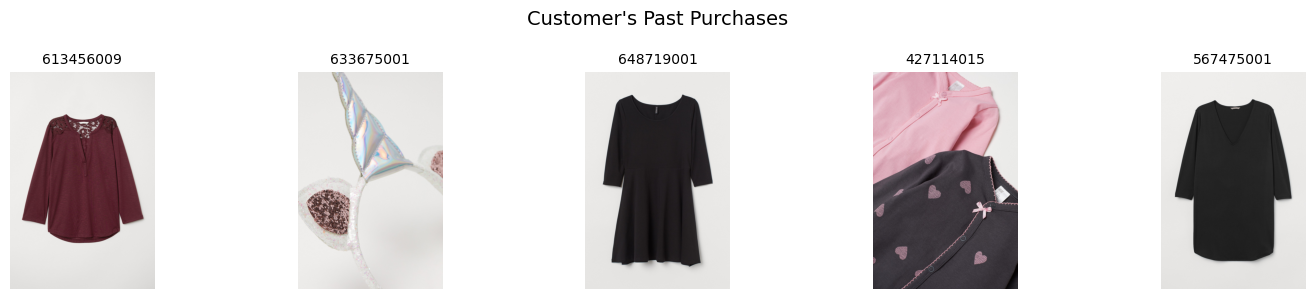

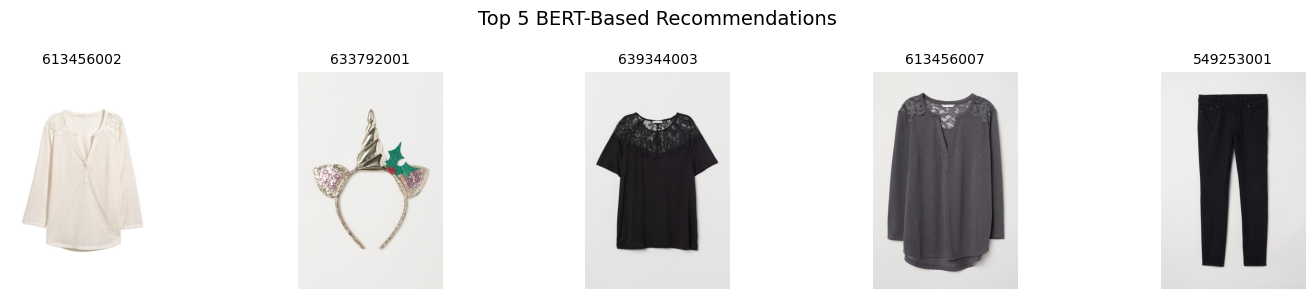

In [75]:
customer_id = transactions_df['customer_id'].iloc[68]  # pick any or specify

recommended, purchased = recommend_for_customer(customer_id)

show_article_images(purchased, "Customer's Past Purchases")
show_article_images(recommended, "Top 5 BERT-Based Recommendations")
